In [1]:
import torch
import torch.nn as nn 
from torchinfo import summary

In [2]:
# 定义第一种残差模块BasicBlock
class BasicBlock(nn.Module):
    # 设置expansion为1，用于计算最终输出特征图的通道数
    expansion = 1
    
    # 构造函数，接收输入通道数inplanes，输出通道数planes，步长stride和下采样层downsample
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        # 定义第一个卷积层，用3x3的卷积核对输入特征图进行卷积，输出通道数为planes，步长为stride，填充为1
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        # BN层
        self.bn1 = nn.BatchNorm2d(planes)
        # 激活函数ReLU
        self.relu = nn.ReLU(inplace=True)
        # 定义第二个卷积层，用3x3的卷积核对输入特征图进行卷积，输出通道数为planes，步长默认为1，填充为1
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1, bias=False)
        # BN层
        self.bn2 = nn.BatchNorm2d(planes)
        # 下采样层，用于调整输入的维度
        self.downsample = downsample
        # 保存步长
        self.stride = stride
    
    # 定义前向传播函数
    def forward(self, x):
        # 保存输入特征图
        identity = x
        
        # 卷积+BN+ReLU
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # 卷积+BN
        out = self.conv2(out)
        out = self.bn2(out)
        
        # 如果定义了下采样层，则调整输入x的维度
        if self.downsample is not None:
            identity = self.downsample(x)
        
        # 将identity和out相加，并使用ReLU激活函数激活
        out += identity
        out = self.relu(out)
        
        # 返回输出特征图
        return out

In [3]:
# 定义第二种残差模块Bottleneck
class Bottleneck(nn.Module):
    # 设置expansion为4，用于计算最终输出特征图的通道数
    expansion = 4
    
    # 构造函数，接收输入通道数inplanes，输出通道数planes，步长stride和下采样层downsample
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        # 定义第一个卷积层，用1x1的卷积核对输入特征图进行卷积，输出通道数为planes
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        # BN层
        self.bn1 = nn.BatchNorm2d(planes)
        # 定义第二个卷积层，用3x3的卷积核对第一个卷积层的输出进行卷积，输出通道数为planes，步长为stride，填充为1
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        # BN层
        self.bn2 = nn.BatchNorm2d(planes)
        # 定义第三个卷积层，用1x1的卷积核对第二个卷积层的输出进行卷积，输出通道数为planes * 4
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        # BN层
        self.bn3 = nn.BatchNorm2d(planes * 4)
        # 激活函数ReLU
        self.relu = nn.ReLU(inplace=True)
        # 下采样层，用于调整输入的维度
        self.downsample = downsample
        # 保存步长
        self.stride = stride
        self.stride = stride

    # 定义前向传播函数
    def forward(self, x):
        # 保存输入特征图
        identity = x
        
        # 卷积+BN+ReLU
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # 卷积+BN+ReLU
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        # 卷积+BN
        out = self.conv3(out)
        out = self.bn3(out)
        
        # 如果定义了下采样层，则调整输入x的维度
        if self.downsample is not None:
            identity = self.downsample(x)
        
        # 将identity和out相加，并使用ReLU激活函数激活
        out += identity
        out = self.relu(out)

In [4]:
# 定义ResNet的网络结构
class ResNet(nn.Module):
    
    # 构造函数，接收残差块类型block、残差块重复次数layers和类别数num_classes
    def __init__(self, block, layers, num_classes=1000):
        super().__init__()
        
        # 定义第一个卷积层，用7x7的卷积核对输入特征图进行卷积，输出通道数为64，步长为2，填充为3
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # BN层
        self.bn1 = nn.BatchNorm2d(64)
        # 激活函数ReLU
        self.relu = nn.ReLU(inplace=True)
        # 定义3x3最大池化层对特征图进行池化，步长为2，填充为1
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # 初始化输入通道数inplanes为64
        self.inplanes = 64
        # 定义layer1，使用_make_layer函数生成一个layer，通道数64，包含layers[0]个block
        self.layer1 = self._make_layer(block, 64, layers[0])
        # 定义layer2，使用_make_layer函数生成一个layer，通道数128，包含layers[1]个block，步长为2
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        # 定义layer3，使用_make_layer函数生成一个layer，通道数256，包含layers[2]个block，步长为2
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        # 定义layer4，使用_make_layer函数生成一个layer，通道数512，包含layers[3]个block，步长为2
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # 平均池化层，输出大小为1x1
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # 定义全连接层，将输入维度设置为512 * block.expansion，输出维度设置为num_classes
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    # 生成网络结构的函数，根据传入的配置，拼接出对应的网络结构
    def _make_layer(self, block, planes, blocks, stride=1):
        # 下采样层，开始为None，用于调整输入的维度
        downsample = None
        # 如果步长不为1或者输入通道数与输出通道数不一致，则需要对输入特征进行调整
        if stride != 1 or self.inplanes != planes * block.expansion:
            # 定义下采样层，包括1x1卷积和BN层
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
    
        # 定义一个layers列表
        layers = []
        # 将第一个block添加到layers列表中
        layers.append(block(self.inplanes, planes, stride, downsample))
        # 更新inplanes为下一个基本块的输入通道数
        self.inplanes = planes * block.expansion
        # 添加剩余的基本块到layers列表中
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
    
        # 返回所有的block
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # 第一部分，7x7卷积+BN+ReLU+最大池化层
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
    
        # 第二部分，4组残差模块
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
    
        # 第三部分，平均池化+全连接层
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
    
        # 输出
        return x

In [5]:
# 封装函数对应5个模型，num_classes表示类别数
# 其中数值与网络结构表格中的数值完全一致，可参考论文结构表
def resnet18(num_classes=1000):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

def resnet34(num_classes=1000):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes)

def resnet50(num_classes=1000):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)

def resnet101(num_classes=1000):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes)

def resnet152(num_classes=1000):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes=num_classes)

In [6]:
# 查看模型结构及参数量，input_size表示示例输入数据的维度信息
summary(resnet34(), input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")# 设置epoch数并开始训练
model = resnet18(num_classes=102).to(device)

In [8]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import *
import numpy as np


# 设置随机种子
torch.manual_seed(0)

# 定义损失函数
criterion = nn.CrossEntropyLoss()

# 设置训练集的数据变换，进行数据增强
trainform_train = transforms.Compose([
    transforms.RandomRotation(30),  # 随机旋转 -30度到30度之间
    transforms.RandomResizedCrop((224, 224)),  # 随机裁剪调整大小进行resize
    transforms.RandomHorizontalFlip(p = 0.5),  # 随机水平翻转
    transforms.RandomVerticalFlip(p = 0.5),  # 随机垂直翻转
    transforms.ToTensor(),  # 将图片转换为张量
    # 对三通道数据进行归一化(均值，标准差)，数值是从ImageNet数据集上的百万张图片中随机抽样计算得到
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 设置测试集的数据变换，不进行数据增强，仅使用resize和归一化
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # resize
    transforms.ToTensor(),  # 将数据转换为张量
    # 对三通道数据进行归一化(均值，标准差)，数值是从ImageNet数据集上的百万张图片中随机抽样计算得到
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 加载训练数据，需要特别注意的是Flowers102数据集，test集的数据量较多些，所以这里使用"test"作为训练集
train_dataset = datasets.Flowers102(root='../data/flowers102', split="test",
                                    download=True, transform=trainform_train)
# 实例化训练数据加载器
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=10, pin_memory=True)

# 加载测试数据，使用"train"作为测试集
test_dataset = datasets.Flowers102(root='../data/flowers102', split="train",
                                   download=True, transform=transform_test)
# 实例化测试数据加载器
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=10, pin_memory=True)

In [9]:
# 设置epoch数并开始训练
num_epochs = 200  # 设置epoch数
loss_history = []  # 创建损失历史记录列表
acc_history = []   # 创建准确率历史记录列表

In [10]:
import sys 

In [15]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [16]:
# tqdm用于显示进度条并评估在每时间开销
for epoch in tqdm(range(num_epochs), file=sys.stdout):
    # 记录损失和预测正确数
    total_loss = 0
    total_correct = 0
    
    # 批量训练
    model.train()
    for inputs, labels in train_loader:
        # 将数据转移到指定计算资源设备上
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # 预测、损失函数、反向传播
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 记录训练集loss
        total_loss += loss.item()
        
        '''
        # 测试模型，不计算梯度
        model.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                # 将数据转移到指定计算资源设备上
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # 预测
                outputs = model(inputs)
                # 记录测试集预测正确数
                total_correct += (outputs.argmax(1) == labels).sum().item()
        
        # 记录训练集损失和测试集准确率
        loss_history.append(np.log10(total_loss))  # 将损失加入损失历史记录列表，由于数值有时较大，这里取对数
        acc_history.append(total_correct / len(test_dataset)) # 将准确率加入准确率历史记录列表
        '''
        
    # 打印中间值
    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                # 将数据转移到指定计算资源设备上
                inputs = inputs.to(device)
                labels = labels.to(device)
                # 预测
                outputs = model(inputs)
                # 记录测试集预测正确数
                total_correct += (outputs.argmax(1) == labels).sum().item()
        loss_history.append(np.log10(total_loss))  # 将损失加入损失历史记录列表，由于数值有时较大，这里取对数
        acc_history.append(total_correct / len(test_dataset)) # 将准确率加入准确率历史记录列表
        tqdm.write("Epoch: {0} Loss: {1} Acc: {2}".format(epoch, loss_history[-1], acc_history[-1]))

Epoch: 0 Loss: 1.2760246487383204 Acc: 0.6882352941176471                       
Epoch: 5 Loss: 1.2171851114682886 Acc: 0.692156862745098                        
Epoch: 10 Loss: 1.279854723698708 Acc: 0.7098039215686275                       
Epoch: 15 Loss: 1.2137873044267666 Acc: 0.7107843137254902                      
Epoch: 20 Loss: 1.2069815958630847 Acc: 0.7098039215686275                      
 11%|████▌                                     | 22/200 [04:22<35:22, 11.92s/it]


KeyboardInterrupt: 

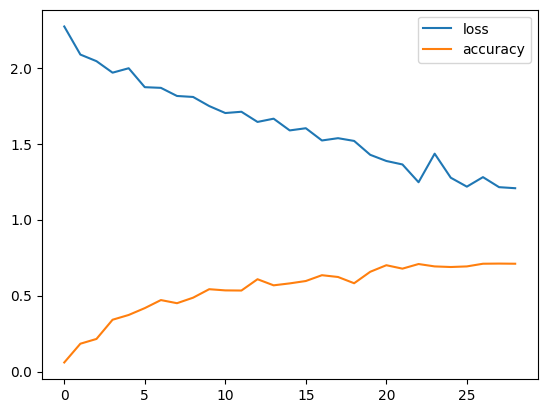

Accuracy: 0.7098039215686275


In [17]:
# 使用Matplotlib绘制损失和准确率的曲线图
import matplotlib.pyplot as plt
plt.plot(loss_history, label='loss')
plt.plot(acc_history, label='accuracy')
plt.legend()
plt.show()

print("Accuracy:",acc_history[-1])